In [1]:
3 + 3

6

In [2]:
papers = {
    'Madison': [10, 14, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
    'Hamilton': [1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22, 23, 24,
                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 59, 60,
                 61, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
                 78, 79, 80, 81, 82, 83, 84, 85],
    'Jay': [2, 3, 4, 5],
    'Shared': [18, 19, 20],
    'Disputed': [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63],
    'TestCase': [64]
}

In [3]:
# A function that compiles all of the text files associated with a single author into a single string
def read_files_into_string(filenames):
    strings = []
    for filename in filenames:
        with open(f'data/federalist_{filename}.txt') as f:
            strings.append(f.read())
    return '\n'.join(strings)
	
# Make a dictionary out of the authors' corpora
federalist_by_author = {}
for author, files in papers.items():
    federalist_by_author[author] = read_files_into_string(files)

 10

The Same Subject Continued (The Union as a Safeguard Against Domestic
Faction and Insurrection)
 1

General Introduction

For the Independent Journal. Saturday, October 27, 1787


HAMILTON

To the
 2

Concerning Dangers from Foreign Force and Influence

For the Independent Journal. Wednesday, Oct
 18

The Same Subject Continued (The Insufficiency of the Present
Confederation to Preserve the Unio
 49

Method of Guarding Against the Encroachments of Any One Department of
Government by Appealing t
 64

The Powers of the Senate

From The Independent Journal. Wednesday, March 5, 1788.

JAY

To the 


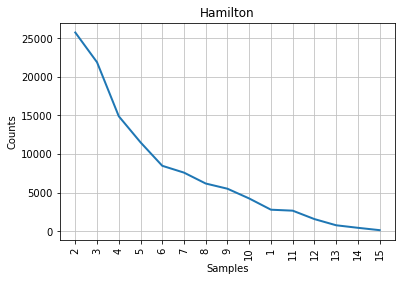

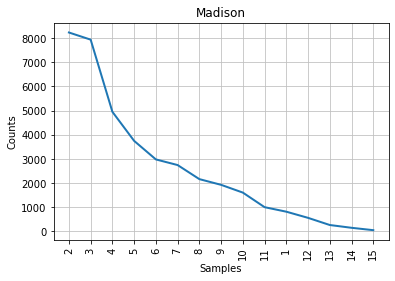

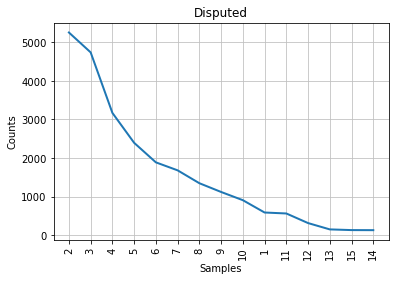

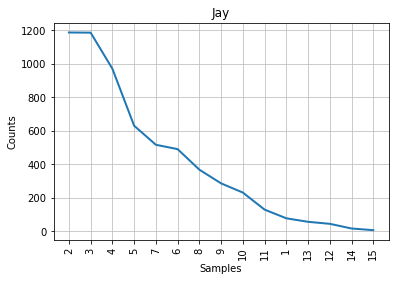

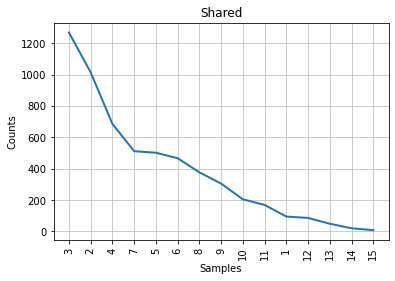

In [4]:
for author in papers:
    print(federalist_by_author[author][:100])

# 1st Mendenhall's characteristic curves of composition	
# Load nltk
import nltk
%matplotlib inline

# Compare the disputed papers to those written by everyone,
# including the shared ones.
authors = ("Hamilton", "Madison", "Disputed", "Jay", "Shared")

# Transform the authors' corpora into lists of word tokens
federalist_by_author_tokens = {}
federalist_by_author_length_distributions = {}
for author in authors:
    tokens = nltk.word_tokenize(federalist_by_author[author])

    # Filter out punctuation
    federalist_by_author_tokens[author] = ([token for token in tokens
                                            if any(c.isalpha() for c in token)])

    # Get a distribution of token lengths
    token_lengths = [len(token) for token in federalist_by_author_tokens[author]]
    federalist_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
    federalist_by_author_length_distributions[author].plot(15,title=author)


In [5]:
# 2nd Kilgariff's 
# Who are the authors we are analyzing?
authors = ("Hamilton", "Madison")

# Lowercase the tokens so that the same word, capitalized or not,
# counts as one word
for author in authors:
    federalist_by_author_tokens[author] = (
        [token.lower() for token in federalist_by_author_tokens[author]])
federalist_by_author_tokens["Disputed"] = (
    [token.lower() for token in federalist_by_author_tokens["Disputed"]])

# Calculate chisquared for each of the two candidate authors
for author in authors:

    # First, build a joint corpus and identify the 500 most frequent words in it
    joint_corpus = (federalist_by_author_tokens[author] +
                    federalist_by_author_tokens["Disputed"])
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))

    # What proportion of the joint corpus is made up
    # of the candidate author's tokens?
    author_share = (len(federalist_by_author_tokens[author])
                    / len(joint_corpus))

    # Now, let's look at the 500 most common words in the candidate
    # author's corpus and compare the number of times they can be observed
    # to what would be expected if the author's papers
    # and the Disputed papers were both random samples from the same distribution.
    chisquared = 0
    for word,joint_count in most_common:

        # How often do we really see this common word?
        author_count = federalist_by_author_tokens[author].count(word)
        disputed_count = federalist_by_author_tokens["Disputed"].count(word)

        # How often should we see it?
        expected_author_count = joint_count * author_share
        expected_disputed_count = joint_count * (1-author_share)

        # Add the word's contribution to the chi-squared statistic
        chisquared += ((author_count-expected_author_count) *
                       (author_count-expected_author_count) /
                       expected_author_count)

        chisquared += ((disputed_count-expected_disputed_count) *
                       (disputed_count-expected_disputed_count)
                       / expected_disputed_count)

    print("The Chi-squared statistic for candidate", author, "is", chisquared)

The Chi-squared statistic for candidate Hamilton is 3434.6850314768426
The Chi-squared statistic for candidate Madison is 1907.5992915766838


In [6]:
# 3rd John Burrow's Delta method
# Feature Selection
# Who are we dealing with this time?
authors = ("Hamilton", "Madison", "Jay", "Disputed", "Shared")

# Convert papers to lowercase to count all tokens of the same word together
# regardless of case
for author in authors:
    federalist_by_author_tokens[author] = (
        [tok.lower() for tok in federalist_by_author_tokens[author]])

# Combine every paper except our test case into a single corpus
whole_corpus = []
for author in authors:
    whole_corpus += federalist_by_author_tokens[author]

# Get a frequency distribution
whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
whole_corpus_freq_dist[ :10 ]

#Calculating features for each subcorpus
# The main data structure
features = [word for word,freq in whole_corpus_freq_dist]
feature_freqs = {}

for author in authors:
    # A dictionary for each candidate's features
    feature_freqs[author] = {}

    # A helper value containing the number of tokens in the author's subcorpus
    overall = len(federalist_by_author_tokens[author])

    # Calculate each feature's presence in the subcorpus
    for feature in features:
        presence = federalist_by_author_tokens[author].count(feature)
        feature_freqs[author][feature] = presence / overall

#Calculating feature averages and standard deviations
import math

# The data structure into which we will be storing the "corpus standard" statistics
corpus_features = {}

# For each feature...
for feature in features:
    # Create a sub-dictionary that will contain the feature's mean
    # and standard deviation
    corpus_features[feature] = {}

    # Calculate the mean of the frequencies expressed in the subcorpora
    feature_average = 0
    for author in authors:
        feature_average += feature_freqs[author][feature]
    feature_average /= len(authors)
    corpus_features[feature]["Mean"] = feature_average

    # Calculate the standard deviation using the basic formula for a sample
    feature_stdev = 0
    for author in authors:
        diff = feature_freqs[author][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(authors) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev

#Calculating z-scores
feature_zscores = {}
for author in authors:
    feature_zscores[author] = {}
    for feature in features:

        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[author][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[author][feature] = ((feature_val-feature_mean) /
                                            feature_stdev)

#Calculating features and z-scores for our test case
# Tokenize the test case
testcase_tokens = nltk.word_tokenize(federalist_by_author["TestCase"])

# Filter out punctuation and lowercase the tokens
testcase_tokens = [token.lower() for token in testcase_tokens
                   if any(c.isalpha() for c in token)]

# Calculate the test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall

# Calculate the test case's feature z-scores
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    print("Test case z-score for feature", feature, "is", testcase_zscores[feature])
#print features z-scores

Test case z-score for feature the is -0.7692828380408238
Test case z-score for feature of is -1.8167784558461264
Test case z-score for feature to is 1.032705844508835
Test case z-score for feature and is 1.0268752924746058
Test case z-score for feature in is 0.6085448502160903
Test case z-score for feature a is -0.9341289591084886
Test case z-score for feature be is 1.0279650702511498
Test case z-score for feature that is 1.7937385529385421
Test case z-score for feature it is -0.13459361853279056
Test case z-score for feature is is -0.9061542167373068
Test case z-score for feature which is -2.059010144513673
Test case z-score for feature by is 1.1019070073046568
Test case z-score for feature as is 4.9191578751913125
Test case z-score for feature this is -1.2530109173143964
Test case z-score for feature not is 0.7961288069167818
Test case z-score for feature would is -0.8319738801201663
Test case z-score for feature for is -1.1476926111838774
Test case z-score for feature have is 2.3422

In [7]:
#Calculating Delta	
for author in authors:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] -
                            feature_zscores[author][feature]))
    delta /= len(features)
    print( "Delta score for candidate", author, "is", delta )
#print Delta score	


Delta score for candidate Hamilton is 1.768470453004334
Delta score for candidate Madison is 1.6089724119682816
Delta score for candidate Jay is 1.5345768956569326
Delta score for candidate Disputed is 1.5371768107570636
Delta score for candidate Shared is 1.846113566619675
